In [17]:
from FairFront import FairFront
from DataLoader_FairFront import load_data
from DiscreteFairFront import *
import numpy as np
import cvxpy as cp
import dccp

import sys
import pandas as pd
import numpy as np

import random
import pickle
import time
from tqdm import tqdm
from time import localtime, strftime

In [18]:
seed_n = 42
random.seed(seed_n)
np.random.seed(seed_n)

In [ ]:
# read in data using the DataLoader module
df = load_data(name='compas', perturbed= False)  
df

In [20]:
# read in perturbed data using pickled dataset 
# df = pd.read_pickle("../data/COMPAS/COMPAS_perturbed_maj0.1_min0.1.pkl")
# df

### Approximate with discrete r.v.

In [21]:
used_columns = df[['age_discrete', 'c_charge_degree', 'gender', 'priors_count',
       'stay_discrete', 'race', 'SY'] ]
      
pmf_dict = {0:{}, 1:{}, 2:{}, 3:{}}

def get_type_count(row):
    sy = row['SY']
    key = (row['age_discrete'],row['c_charge_degree'],row['gender'],row['priors_count'], row['stay_discrete'], row['race'])
    if key not in pmf_dict[sy]:
        pmf_dict[sy].update({key: 1})
    else:
        pmf_dict[sy][key] =  pmf_dict[sy][key] + 1
    

for index, row in used_columns.iterrows():
    get_type_count(row)

for i in range(4):
    total_i = sum(pmf_dict[i].values())
    pmf_dict[i] = {key: value / total_i for key, value in pmf_dict[i].items()}


In [22]:
# output support as a list 
support_list = []
for i in range(4):
    support_list += list(pmf_dict[i].keys())

support_X = list(set(support_list)) # support of input features
calX = len(support_X) # support size of input features
calX


1640

In [23]:
def get_pmf(dictionary, x):
    '''
    if x is in dictionary pmf_dict[i], then use that value. If not, fill in 0
    '''
    if x in dictionary:
        return dictionary[x]
    else:
        return 0 

# transition matrix from (s,y) to x
T_SY_X  = np.vstack([[get_pmf(pmf_dict[0], x) for x in support_X], \
           [get_pmf(pmf_dict[1], x) for x in support_X], \
           [get_pmf(pmf_dict[2], x) for x in support_X], \
           [get_pmf(pmf_dict[3], x) for x in support_X]
            ])

T_SY_X.shape


(4, 1640)

#### Obtain transition matrix and conditional distribution

In [24]:
A = 2
C = 2
sensitive_s = 'race'
label_y = 'is_recid'
# get the mu_s,y values, encoded in matrix mu_SY
mu_SY = np.zeros((A, C))
mu_SY = np.zeros((2, 2))
for index, row in df.iterrows():
    s,y = int(row[sensitive_s]), int(row[label_y])
    mu_SY[s][y] = mu_SY[s][y] + 1
mu_SY = mu_SY/len(df)

map_ind_X = dict(zip(range(calX), support_X))
map_X_ind = dict(zip(support_X, range(calX)))

In [25]:
def g_emp(x):
    '''
    compute g function from the empirical distribution
    '''
    result_vector = []
    ind_x = map_X_ind[x]
    for s in range(A):
        for y in range(C):
            result_vector.append(T_SY_X[s*C + y, ind_x] * mu_SY[s][y])
    #normalize
    result_vector = result_vector/(sum(result_vector))
    return result_vector

In [26]:
distinf = {"T": T_SY_X, "map": map_ind_X, "mu_SY": mu_SY}

#### Generate FairFront

In [27]:
# fairness threshold
alpha_SP = 1.0
alpha_OAE = 1.0

epsilon = []
opt_list = []
opt_discrete_list = []

for i in np.linspace(0,0.1,10):
    print("current i:", i)
    epsilon.append(i)
    start_time = time.localtime()
    #FairFront_value = FairFront(A, C, g_emp, sensitive_s = sensitive_s, label_y=label_y, InputDist = True, dist_inf = distinf, alpha_SP = alpha_SP, alpha_EO = i , alpha_OAE = alpha_OAE, max_iterations = 1)

    #optimal_value,_,_ = FairFront_value.Algorithm()
    #opt_list.append(optimal_value)

    FairFront_discrete = DiscreteFairFront(A, C, mu_SY, distinf, alpha_SP = alpha_SP, alpha_EO = i, alpha_OAE = alpha_OAE)
    value = FairFront_discrete.FairFront()
    opt_discrete_list.append(value)
    

    print('Time for this iteration: {:4.3f} mins\n'.format((time.mktime(time.localtime()) - time.mktime(start_time))/60))
    print("true_opt_list:", opt_discrete_list)

        

current i: 0.0
Time for this iteration: 0.017 mins

true_opt_list: [0.7619731112214649]
current i: 0.011111111111111112
Time for this iteration: 0.017 mins

true_opt_list: [0.7619731112214649, 0.7684459292938178]
current i: 0.022222222222222223
Time for this iteration: 0.017 mins

true_opt_list: [0.7619731112214649, 0.7684459292938178, 0.7695894747671452]
current i: 0.03333333333333333
Time for this iteration: 0.017 mins

true_opt_list: [0.7619731112214649, 0.7684459292938178, 0.7695894747671452, 0.7700426484061318]
current i: 0.044444444444444446
Time for this iteration: 0.017 mins

true_opt_list: [0.7619731112214649, 0.7684459292938178, 0.7695894747671452, 0.7700426484061318, 0.7704106284609922]
current i: 0.05555555555555556
Time for this iteration: 0.017 mins

true_opt_list: [0.7619731112214649, 0.7684459292938178, 0.7695894747671452, 0.7700426484061318, 0.7704106284609922, 0.7707584703957764]
current i: 0.06666666666666667
Time for this iteration: 0.017 mins

true_opt_list: [0.761

In [28]:
# fairness threshold
alpha_SP = 1.0
alpha_OAE = 1.0

for i in np.linspace(0.111,0.23,6):
    print("current i:", i)
    epsilon.append(i)
    start_time = time.localtime()
    #FairFront_value = FairFront(A, C, g_emp, sensitive_s = sensitive_s, label_y=label_y, InputDist = True, dist_inf = distinf, alpha_SP = alpha_SP, alpha_EO = i , alpha_OAE = alpha_OAE, max_iterations = 1)

    #optimal_value,_,_ = FairFront_value.Algorithm()
    #opt_list.append(optimal_value)

    FairFront_discrete = DiscreteFairFront(A, C, mu_SY, distinf, alpha_SP = alpha_SP, alpha_EO = i, alpha_OAE = alpha_OAE)
    value = FairFront_discrete.FairFront()
    opt_discrete_list.append(value)
    
    print('Time for this iteration: {:4.3f} mins\n'.format((time.mktime(time.localtime()) - time.mktime(start_time))/60))
    print("true_opt_list:", opt_discrete_list)

        

current i: 0.111
Time for this iteration: 0.017 mins

true_opt_list: [0.7619731112214649, 0.7684459292938178, 0.7695894747671452, 0.7700426484061318, 0.7704106284609922, 0.7707584703957764, 0.7710930041862103, 0.7713712130304804, 0.7715043576575572, 0.7715043575931407, 0.7715043568850914]
current i: 0.1348
Time for this iteration: 0.017 mins

true_opt_list: [0.7619731112214649, 0.7684459292938178, 0.7695894747671452, 0.7700426484061318, 0.7704106284609922, 0.7707584703957764, 0.7710930041862103, 0.7713712130304804, 0.7715043576575572, 0.7715043575931407, 0.7715043568850914, 0.7715043576321082]
current i: 0.15860000000000002
Time for this iteration: 0.017 mins

true_opt_list: [0.7619731112214649, 0.7684459292938178, 0.7695894747671452, 0.7700426484061318, 0.7704106284609922, 0.7707584703957764, 0.7710930041862103, 0.7713712130304804, 0.7715043576575572, 0.7715043575931407, 0.7715043568850914, 0.7715043576321082, 0.7715043570469583]
current i: 0.1824
Time for this iteration: 0.017 mins



In [29]:
for i in [0.003703703703703704, 0.003703703703703704*2, 0.016666666666666666]:
    print("current i:", i)
    epsilon.append(i)
    start_time = time.localtime()
    #FairFront_value = FairFront(A, C, g_emp, sensitive_s = sensitive_s, label_y=label_y, InputDist = True, dist_inf = distinf, alpha_SP = alpha_SP, alpha_EO = i , alpha_OAE = alpha_OAE, max_iterations = 1)

    #optimal_value,_,_ = FairFront_value.Algorithm()
    #opt_list.append(optimal_value)

    FairFront_discrete = DiscreteFairFront(A, C, mu_SY, distinf, alpha_SP = alpha_SP, alpha_EO = i, alpha_OAE = alpha_OAE)
    value = FairFront_discrete.FairFront()
    opt_discrete_list.append(value)
    
    print('Time for this iteration: {:4.3f} mins\n'.format((time.mktime(time.localtime()) - time.mktime(start_time))/60))
    print("true_opt_list:", opt_discrete_list)

        

current i: 0.003703703703703704
Time for this iteration: 0.017 mins

true_opt_list: [0.7619731112214649, 0.7684459292938178, 0.7695894747671452, 0.7700426484061318, 0.7704106284609922, 0.7707584703957764, 0.7710930041862103, 0.7713712130304804, 0.7715043576575572, 0.7715043575931407, 0.7715043568850914, 0.7715043576321082, 0.7715043570469583, 0.7715043576287883, 0.7715043545696117, 0.7715043557388052, 0.7642010876045531]
current i: 0.007407407407407408
Time for this iteration: 0.017 mins

true_opt_list: [0.7619731112214649, 0.7684459292938178, 0.7695894747671452, 0.7700426484061318, 0.7704106284609922, 0.7707584703957764, 0.7710930041862103, 0.7713712130304804, 0.7715043576575572, 0.7715043575931407, 0.7715043568850914, 0.7715043576321082, 0.7715043570469583, 0.7715043576287883, 0.7715043545696117, 0.7715043557388052, 0.7642010876045531, 0.7664290623264307]
current i: 0.016666666666666666
Time for this iteration: 0.017 mins

true_opt_list: [0.7619731112214649, 0.7684459292938178, 0.769

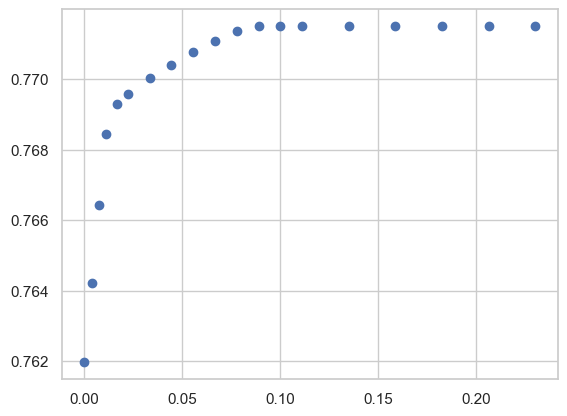

In [30]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
sns.set(style="whitegrid")

plt.plot(epsilon, opt_discrete_list, 'o')